# Introduction:
### In this analysis, I explore binary classification techniques to predict recovery from lung disease using four different models: Logistic Regression, Random Forest, XGBoost and LightGBM.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.simplefilter('ignore')

# 1. Exploratory Data Analysis (EDA) and Visualization
### In this section, I performed exploratory data analysis to better understand the dataset and visualize important features related to recovery status.

* Recovery Status: A count plot of recovery status distribution.
* Numerical Features: Overlapping histgrams, with different colors for recovered and non-recovered individuals.
* Categorical Features: Count plots showing categorical variables, with colors separating recovered and non-recovered individuals.

The correlations between features were visualized after preprocessing.

In [3]:
## Data loading
df = pd.read_csv("/kaggle/input/lungs-diseases-dataset/lung_disease_data.csv")
df.head()

,Age,Gender,Smoking Status,Lung Capacity,Disease Type,Treatment Type,Hospital Visits,Recovered
0,71.0,Female,No,4.49,COPD,Therapy,14.0,Yes
1,34.0,Female,Yes,NaN,Bronchitis,Surgery,7.0,No
2,80.0,Male,Yes,1.95,COPD,NaN,4.0,Yes
3,40.0,Female,Yes,NaN,Bronchitis,Medication,1.0,No
4,43.0,Male,Yes,4.60,COPD,Surgery,NaN,Yes


In [4]:
df.shape

(5200, 8)

In [5]:
df.describe()

,Age,Lung Capacity,Hospital Visits
count,4900.000000,4900.000000,4900.000000
mean,54.449796,3.501865,7.528571
std,20.126882,1.461179,3.996401
min,20.000000,1.000000,1.000000
25%,37.000000,2.220000,4.000000
50%,54.000000,3.480000,8.000000
75%,72.000000,4.800000,11.000000
max,89.000000,6.000000,14.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              4900 non-null   float64
 1   Gender           4900 non-null   object 
 2   Smoking Status   4900 non-null   object 
 3   Lung Capacity    4900 non-null   float64
 4   Disease Type     4900 non-null   object 
 5   Treatment Type   4900 non-null   object 
 6   Hospital Visits  4900 non-null   float64
 7   Recovered        4900 non-null   object 
dtypes: float64(3), object(5)
memory usage: 325.1+ KB


In [7]:
## Divide columns based on feature type: numerical or categorical

cat_cols = []
num_cols = []
target_col = []

for col in df:
    if col == 'Recovered':
        target_col.append(col)
    
    elif df[col].dtype == 'object':
        cat_cols.append(col)

    else:
        num_cols.append(col)

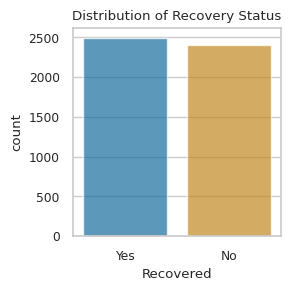

In [8]:
## Count plot of Recovery status

sns.set(font_scale = 0.8, palette='colorblind', style='whitegrid')

plt.figure(figsize = (3,3))
sns.countplot(df, x = 'Recovered', alpha = 0.7)
plt.title('Distribution of Recovery Status')

plt.tight_layout()
plt.show()

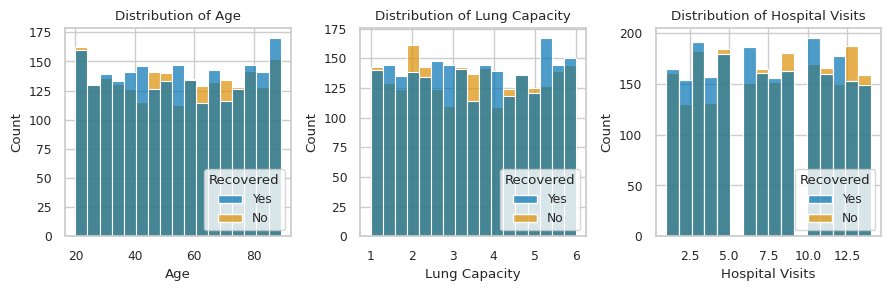

In [9]:
## Histograms of Numerical features

fig, axes = plt.subplots(1, 3, figsize = (9, 3))
axes = axes.ravel()

for col, ax in zip(num_cols, axes):
    sns.histplot(df, x=col, hue='Recovered', ax = ax, alpha = 0.7)
    sns.move_legend(ax, 'lower right')
    ax.set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

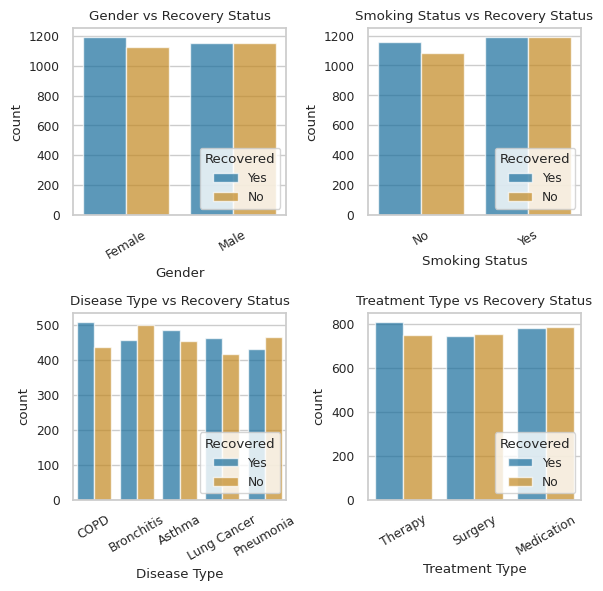

In [10]:
## Count plots of Categorical features

fig, axes = plt.subplots(2, 2, figsize = (6, 6))
axes = axes.ravel()

for col, ax in zip(cat_cols, axes):
    sns.countplot(df, x = col, hue = 'Recovered', ax = ax, alpha = 0.7)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    sns.move_legend(ax, 'lower right')
    ax.set_title(f"{col} vs Recovery Status")

plt.tight_layout()
plt.show()

# 2. Data Preprocessing
### In this section, I processed the data to prepare it for model training. After that, I visualized the correlations between features.
## 2.1 Handling Missing Values
* Numerical features: Missing values were filled with the median of each feature. 
* Categorical features: Missing values were filled with the mode of each feature. 
* Recovery status: Rows with missing recovery status were dropped.

In [11]:
## Handling missing values
## Processed dataset -->> df_im
df_im = df.copy()

for col in num_cols:
    df_im[col] = df_im[col].fillna(df_im[col].median())

for col in cat_cols:
    md = df_im[col].mode()[0]
    df_im[col] = df_im[col].fillna(md)

df_im = df_im.dropna(subset = target_col)
print(df_im.isnull().sum())

Age                0
Gender             0
Smoking Status     0
Lung Capacity      0
Disease Type       0
Treatment Type     0
Hospital Visits    0
Recovered          0
dtype: int64


## 2.2 Handling Categorical Variables
* I used Label Encoding to convert categorical variables into numerical values.
* Specifically, I transformed the recovery status ('Yes'->1, 'No'->0) using the map() function.

In [12]:
## Label encoding
## Processed dataset -->> df_le

df_le = df_im.copy()
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df_le[col] = le.fit_transform(df_le[col])
    label_list = le.classes_
    print("{}: {} -->> {}".format(col, label_list, [i for i in range(len(label_list))]))

## Convert recovery status
df_le['Recovered'] = df_le['Recovered'].map({'Yes':1, 'No':0})
print("{}: ['No', 'Yes'] -->> [0, 1]".format(*target_col))

Gender: ['Female' 'Male'] -->> [0, 1]
Smoking Status: ['No' 'Yes'] -->> [0, 1]
Disease Type: ['Asthma' 'Bronchitis' 'COPD' 'Lung Cancer' 'Pneumonia'] -->> [0, 1, 2, 3, 4]
Treatment Type: ['Medication' 'Surgery' 'Therapy'] -->> [0, 1, 2]
Recovered: ['No', 'Yes'] -->> [0, 1]


## 2.3 Visualizing Correlations
I visualized the correlation coefficients between the features to better understand the relationships betwwen them.

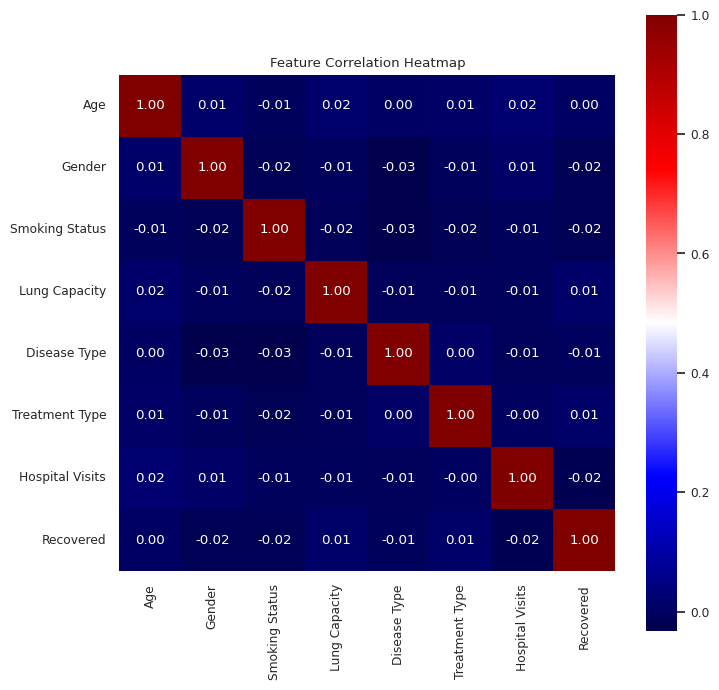

In [13]:
## Correlation coefficients between features
plt.figure(figsize=(8,8))
sns.heatmap(df_le.corr(), square=True, annot=True, fmt=".2f", cmap='seismic')
plt.title("Feature Correlation Heatmap")
plt.show()

# 3. Model Training & Evaluation
### In this section, I trained four different models for binary classification: Logistic Regression, Random Forest, XGBoost and LightGBM. 
### I then evaluated their performance using various metrics, including accuracy, precision, recall, F1-score, and AUC.
### Finally, I visualized the feature importances for each model.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [15]:
## Split the dataset into train(80%) and test(20%)
X = df_le.drop(columns = ['Recovered'])
y = df_le['Recovered']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12)

In [16]:
## Train models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators = 100, random_state = 42),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(f'{name} AUC: {roc_auc_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.5173
Logistic Regression AUC: 0.5166
              precision    recall  f1-score   support

           0       0.52      0.33      0.40       488
           1       0.51      0.71      0.60       492

    accuracy                           0.52       980
   macro avg       0.52      0.52      0.50       980
weighted avg       0.52      0.52      0.50       980

Random Forest Accuracy: 0.5276
Random Forest AUC: 0.5276
              precision    recall  f1-score   support

           0       0.53      0.53      0.53       488
           1       0.53      0.52      0.53       492

    accuracy                           0.53       980
   macro avg       0.53      0.53      0.53       980
weighted avg       0.53      0.53      0.53       980

XGBoost Accuracy: 0.5265
XGBoost AUC: 0.5266
              precision    recall  f1-score   support

           0       0.52      0.53      0.53       488
           1       0.53      0.52      0.52       492

    accurac

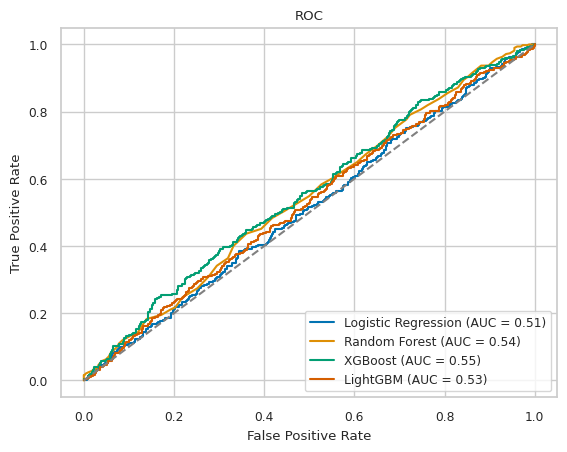

In [17]:
## Plot ROC curve
plt.figure()

for name, model in models.items():
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc = 'lower right')
plt.show()

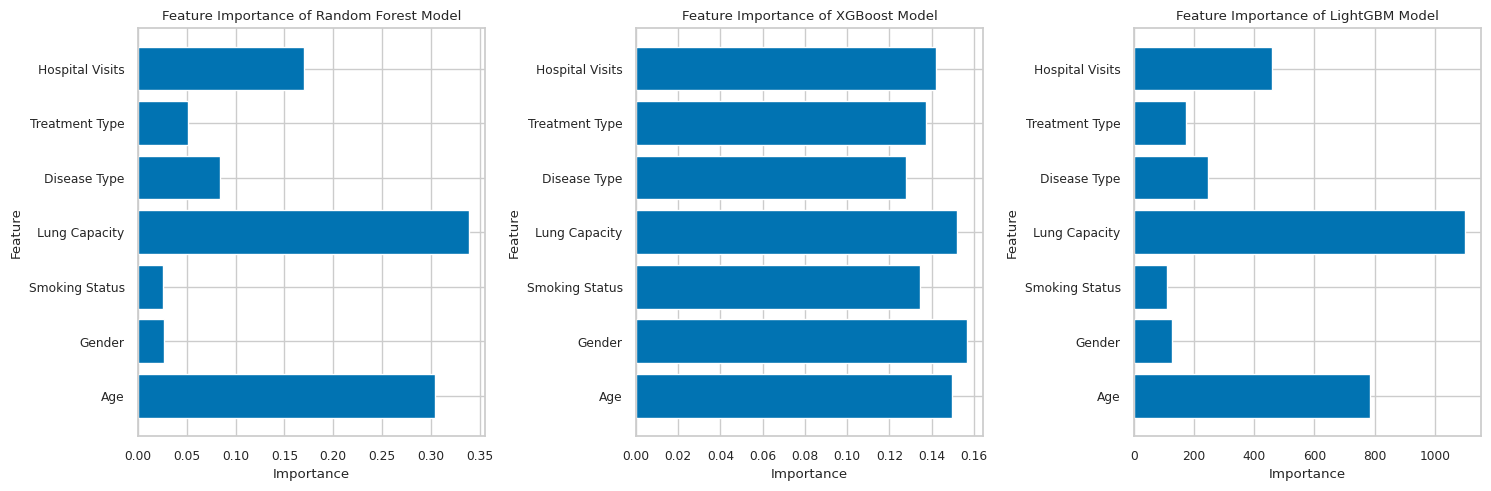

In [18]:
## Visualizing feature importance
dt_models = models.copy()
del dt_models['Logistic Regression']

fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes = axes.ravel()

for name, model, ax in zip(dt_models.keys(), dt_models.values(), axes):

    feature_importance = model.feature_importances_
    features = X_train.columns
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
    ax.barh(importance_df['Feature'], importance_df['Importance'])
    ax.set_xlabel('Importance')
    ax.set_ylabel('Feature')
    ax.set_title(f'Feature Importance of {name} Model')

plt.tight_layout()
plt.show()

# Conclusion:
* These results suggest that the current features may not fully capture the patterns needed for accurate recovery prediction, as indicated by the low model performance and weak correlations among features.
* Including more relevant factors, such as biochemical markers, genetic data, medication type, severity, symptoms, complications, and length of treatment, could improve prediction.
* While tree-based models were tested, alternative approaches, such as deep learning, might be worth exploring.  
This project was a valuable learning experience, and I appreciate the opportunity to work with this dataset.